<a href="https://colab.research.google.com/github/mertyyanik/Analysis-with-R/blob/master/Seminer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yüz Tespiti ve Optimizasyonu

Yüz algılama, dijital fotoğraflarda ve videolarda insan yüzlerinin varlığını tanımlayabilen ve bulabilen yapay zeka tabanlı bir bilgisayar teknolojisidir. Özel bir nesne sınıfı algılama durumu olarak kabul edilebilir, burada görev belirli bir görüntü veya görüntüler içindeki belirli bir sınıfa (bu durumda yüzlere) ait konumları bulmak ve boyutlarını belirtmektir.

Yüz algılama uygulamaları, genellikle manzaralar, binalar ve ayak veya el gibi diğer insan vücudu parçaları gibi diğer yüz olmayan nesneleri içeren daha büyük görüntülerdeki insan yüzlerini bulmak için algoritmalar ve makine öğrenmesi kullanır. Yüz algılama algoritmaları, genellikle tespit edilmesi en kolay özelliklerden biri olan insan gözlerini arayarak başlar. Algoritma daha sonra kaşları, ağzı, burnu, burun deliklerini ve irisi tespit etmeye çalışabilir.

Resimlerdeki yüzlerin algılanması poz, ifade, konum ve yönelim, ten rengi ve piksel değerleri, gözlük veya yüz kıllarının varlığı, aydınlatma koşulları ve görüntü çözünürlüğü gibi faktörlerin değişkenliği nedeniyle karmaşık olabilir. Son yıllarda, geleneksel bilgisayar görme yöntemlerinden önemli ölçüde daha iyi performans göstermenin avantajını sunan derin öğrenmeyi kullanarak yüz tanımada gelişmeler sağlanmıştır.

Multi-task Cascaded Convolutional Networks(MTCNN), günümüzde derin öğrenme aracılığı ile yüz tespiti yapan en başarılı algoritmalardan biridir. Önceden eğitilmiş(pre-trained) bir model barındırdığı için aslında tek yapılması gereken kütüphaneyi çağırmak ve modele bir resim vermektir.

Bunun için öncelikle MTCNN Python kütüphanesinin kurulması gerekmektedir.

In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 8.0MB/s 


Daha sonra hem MTCNN hem de veri ön işleme aşamaları için lazım olan bazı kütüphanelerin hazır hale getilmesi gerekiyor. Bu kütüphaneler Colab ortamında hali hazırda yüklenmiştir. Sizde yoksa yukarıda MTCNN'in yüklendiği şekilde diğer kütüphaneleri kurmanız gerekmektedir.

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mtcnn.mtcnn import MTCNN as MTCNN_1

Using TensorFlow backend.


Kütüphane kurulumları tamamlandıktan sonra, içerisinde yüzleri tespit etmek istediğimiz videonun yolunu(path) aşağıya giriyoruz.

In [0]:
VIDEO_PATH = '/content/bndfldavtx.mp4'

Yüz tespiti için algoritma bizden video değil resim istiyor. Dolayısıyla resimlerin ardı sıra birleştirilmesiyle oluşturulan videoların, resimlerine ayrılması gerekmektedir. Bunun için ufak bir fonksiyon yazıyoruz. CV2 kütüphanesi videoyu yakalıyor ve içindeki resimleri sonsuz bir döngü içerisinde kaydediyor. Kütüphane resim bulamayana kadar bu süreç devam ediyor.

In [0]:
def extract_frames(VIDEO_PATH):
  frames_list = []
  vidcap = cv2.VideoCapture(VIDEO_PATH)
  success,image = vidcap.read()
  
  while success:
    frames_list.append(image)
    success,image = vidcap.read()

  return frames_list

frames_list = extract_frames(VIDEO_PATH)

Resimleri(frame) çıkarttık ve bunu frames_list listesine kaydettik. Artık bu liste aracılığı ile yüz çıkartma işlemi yapabileceğiz.

Aşağıda çıkartılan resimlerden 1 tanesi görülmektedir. Kişinin ten renginin ne kadar koyu olduğuna dikkat edin ,bu yüz tespitinin bir hayli zor olacağı anlamına geliyor.

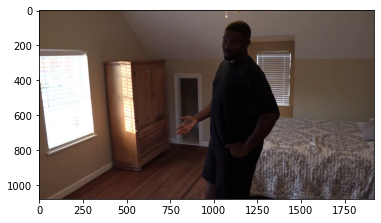

In [0]:
plt.imshow(cv2.cvtColor(frames_list[0], cv2.COLOR_BGR2RGB))

Şimdi çıkarttığımız resimlerin kaç tane olduğuna ve her birinin boyutuna bakalım.

In [0]:
frames_list = np.array(frames_list)
frames_list.shape

(300, 1080, 1920, 3)

Yukarıda görüldüğü üzere videoda toplamda 300 tane resim(frame) var ve her biri (1080, 1920, 3) boyutuna sahip. Burada (3) katman(channel) yani resmin renkli olmasını sağlayan kısım. (1080, 1920) ise çözünürlülük.

Şimdi sırada yüz tespit kısmı. Elimizdeki resimler (1080, 1920) çözünürlüğe sahip olduğu için bu yüz tespit işlemi bir kaç dakika sürecektir.

Öncellikle tek bir resimden yüz tespiti yapması için gereken fonksiyonu yazıyoruz. Burada MTCNN'in içerisinden detector isminde bir nesne oluşturuyoruz ve bu nesnenin içindeki detect_faces fonksiyonu ile yüz tespitini gerçekleştiriyoruz. MTCNN bize yüz tespitini gerçekleştirdikten sonra birden fazla bilgi sunuyor, bu bilgilerden bize lazım olan yüzün resim üzerindeki konum bilgileri. Bu bilgiler; x1, y1, genişlik ve yükseklik bilgileri. Bunu 'box' anahtar kelimesi ile alıyoruz.

In [0]:
def detect_faces(image):
  face_list = []

  detector = MTCNN_1()
  faces = detector.detect_faces(image)

  if faces == []:
    return 0

  for face_num in range(len(faces)):
    try:
      x1, y1, width, height = faces[face_num]['box']
      x2, y2 = x1 + width, y1 + height
      face = image[y1:y2, x1:x2]
      face_list.append(face)
    except:
      continue

  return face_list

Bu noktadan sonra artık elimizde bulunan frames_list listesinin içerisindeki her bir resmin yüz tespitini gerçekleştiriyor ve bunu faces_list listesine yazıyoruz. Bu işlemin ne kadar zaman aldığını görmek için bir sayaç yerleştirdik.

In [0]:
import time
tic = time.time()

faces_list_mtcnn = []

for frame in frames_list:
  faces = detect_faces(frame)

  if faces != 0:
    faces_list_mtcnn.append(faces)
    
toc = time.time()
print(toc- tic)

245.70191192626953


Görüldüğü üzere yüz tespit işlemi başarıyla gerçekleşti ve bu işlem 245 saniye sürdü. Bunun temeldeki sebebi yüz tespit algoritmasının bu işlemi CPU üzerinden yapıyor olması ve resimlerin çözünürlülüğünün çok yüksek olması.

Tespit edilen yüzlerden bir tanesine bakalım.

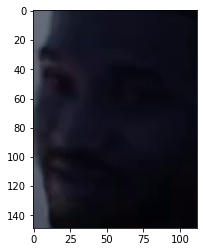

In [0]:
plt.imshow(faces_list_mtcnn[0][0])

Burada yüz tespinin hızı çok önemli. Zaman olarak bu kadar maaliyetli bir algoritmayla güzel işler yapamazsınız çünkü kimse 234 saniye beklemek istemez.

Bu nedenle bu sorunu çözmek adına MTCNN üzerinde bir kaç iyileştirme yaptık ve bu projeyi Github üzerinden paylaştık. Yaptığımız temel değişiklik, MTCNN'i pytorch kütüphanesi ve GPU desteği ile hızlandırmaktı. Bu projenin çalışabilmesi için bilgisayarınızda Pytorch ve Compute Unified Device Architecture(CUDA) kurulu olması gerekmektedir. Colab ortamı bize ücretsiz GPU desteği veriyor ve bu kütüphanelerin tamamı hali hazırda kurulu.

Öncelikle projeyi github ortamından lokal ortamımıza indirelim.

In [0]:
!pip install dface

Bundan sonraki aşamalar hemen hemen aynı. Tek farkı güncellediğimiz MTCNN'in detect fonksiyonu içerisine resim değil bu resimlerden oluşan listeyi istiyor olması. Yani aslında işimiz daha kolay.

In [0]:
import math
from dface import MTCNN as MTCNN_2
import time

faces_list_dface = []

tic = time.time()

mtcnn = MTCNN_2('cuda')

result = mtcnn.detect(frames_list)
for num, res in enumerate(result):
    if res is None:
        continue
    boxes, probs, lands = res

    boxes = boxes.reshape(4)

    x1, y1, x2, y2 = boxes[0], boxes[1], boxes[2], boxes[3]

    face = frames_list[num][int(y1):int(y2), int(x1):int(x2)]
    faces_list_dface.append(face)

toc = time.time()
print(toc - tic)

Downloading: "https://github.com/deepware/dFace/raw/master/models/mtcnn.pt" to /root/.cache/torch/checkpoints/mtcnn.pt



14.499074220657349


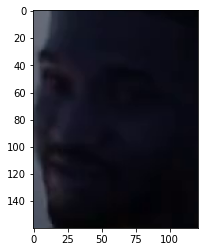

In [0]:
plt.imshow(faces_list_dface[0])

Görüldüğü üzere hazırladığımız kütüphane yüz tespitini 14 saniyede bitirdi. İnanılmaz büyük bir hız farkı oluştu.

Fakat her iki kütüphanede de temel bir problem var. Elimizdeki videoda 300 resim vardı. Bu demek oluyor ki videodan 300 tane yüz tespit edilmesi gerekiyor çünkü kişi video kadrajından hiç çıkmamış. Peki kullandığımız algoritma kaç tane tespit etti?

In [0]:
len(faces_list_mtcnn)

176

300 yüzden sadece 176 tanesini tespit edebilmiş. Buradaki sorun videodaki kişinin ten renginin koyu olması ve videonun çekildiği ortamın ışıklandırmasının yetersiz olması.

Bu sorunu çözmek için istatistiksel bir yöntem olan adaptif histogram eşitlemesini kullanacağız.

Piksel değerleri yalnızca belirli bir değer aralığıyla sınırlı bir görüntü düşünün. Örneğin parlak bir görüntünün pikselleri yüksek değerlerin olduğu bir bölgede sınırlıdır. Aynı şey bizim örneğimiz içinde geçerli. Bu videoda görüntü piksel değerlerinin düşük olduğu bölgelerde sınırlı ki bu sebepten dolayı görüntünün çoğunluğu karanlık.

Bu nedenle bu sorunu çözmek için histogramın her iki ucunu sağa ve sola uzatmamız gerekiyor ki temsil ettiği piksel aralığı daha geniş olsun. Adaptif histogram eşitlemesinin yaptığı şey tam olarak budur.

![Adaptive Histogram Equalization](https://i.hizliresim.com/6i5Ejg.png)

Cv2 kütüphanesin içerisinde adaptif histogram eşitlemesi için fonksiyon bulunmaktadır. Bu fonksiyonu resmin üçüncü boyutunu yani renkli kısmını koruyacak şekilde çağırıyoruz.

In [0]:
def adaptive_histogram_equalization(frame):
    img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])

    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

Daha sonra videodan çıkarttığımız her bir frame üzerine bu işlemi gerçekleştiriyoruz.

In [0]:
adaptive_frames_list = []

for frame in frames_list:
  adaptive_frame = adaptive_histogram_equalization(frame)
  adaptive_frames_list.append(adaptive_frame)

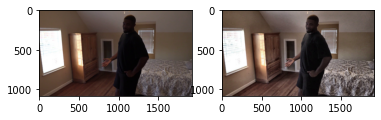

In [0]:
f, axarr = plt.subplots(1,2)

axarr[0].imshow(cv2.cvtColor(frames_list[0], cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(adaptive_frames_list[0], cv2.COLOR_BGR2RGB))


Sol taraftaki resim adaptif histogram eşitlemesi uygulanmadan önceki sağdaki resim uygulandıktan sonraki halidir. Resim üzerinde çok net bir şekilde parlaklığın arttığını ve yüz bölgesinin daha net olduğu görülmektedir.

Şimdi yüz tespit algoritmasını tekrar çalıştıralım ve kaç tane yüz tespit edebildiğine tekrar bakalım. Bunun eski ve yavaş olan yüz tespit algoritmasını kullanalım. Bu nedenle bu işlem biraz zaman alacak.

In [0]:
adaptive_faces_list = []

for frame in adaptive_frames_list:
  faces = detect_faces(frame)

  if faces != 0:
    adaptive_faces_list.append(faces)

In [0]:
len(faces_list_mtcnn), len(adaptive_faces_list)

(176, 278)

Görüldüğü üzere ilk başta 176 olan sayı eşitleme sonucu 278'e çıkmıştır. Bu durumda algoritmanın başarılı çalıştığını söyleyebiliriz.

**Hazırlayan : Mert Yanık**

**Numara : 21522134**

# Referanslar

https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html

https://en.wikipedia.org/wiki/Histogram_equalization

https://github.com/ipazc/mtcnn

https://github.com/deepware/dface
